## Set Workspace


In [1]:
%matplotlib inline

import os
import re
from datetime import datetime
import math

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
plt.rc('xtick', labelsize='small')
plt.rc('ytick', labelsize='small')
std_figsize = (4, 4)

# Set the seed for replicable results
seed = 0
np.random.seed(seed)
tf.set_random_seed(seed)

# Helper variables
eps = 0.00001  # Small epsilon value

# Make output directory to save network weights and starting point
if not os.path.exists('./output'):
    os.mkdir('./output')

# Path to saved tensorflow session
sess_path = None
# Path to saved data starting point
data_path = None

Instructions for updating:
non-resource variables are not supported in the long term


## Set utils functions

In [2]:
def initialize_nn_weight(dim):
    """Initialize neural network weight or bias variable.

    Args:
        dim <list>: dimensions of weight matrix.
                    - if len(dim) == 1: initializes bias,
                    - if len(dim) == 2: initializes weight.

    Returns:
        Tensor variable of normally initialized data.

    """
    t_stnd = tf.sqrt(tf.cast(dim[0], tf.float32)) * 10
    return tf.Variable(tf.random.normal(tf.cast(dim, tf.int32)) / t_stnd, trainable=True)


def random_mini_batches(X, minibatch_size=64, seed=0):
    """Generate random minibatches from X.

    Args:
        X <array>: Input data to be mini-batched.
        minibatch_size <int>: mini-batch size.
        seed <int>: seed.

    Returns:
        List of mini-batches generated from X.

    """
    np.random.seed(seed)
    m = X.shape[0]
    mini_batches = []

    # Step 1: Shuffle X
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :]

    # Step 2: Partition shuffled_X. Minus the end case.
    # number of mini batches of size mini_batch_size in your partitionning
    num_complete_minibatches = int(math.floor(m / minibatch_size))

    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[(k * minibatch_size):((k+1) * minibatch_size), :]
        mini_batch = (mini_batch_X)
        mini_batches.append(mini_batch)

    return mini_batches

## Set parameters

In [3]:
# Number of agents and exogenous shocks
num_agents = A = 6
num_exogenous_shocks = 4

# Capital and TFP
delta = tf.constant(0.5,  dtype=tf.float32)  # Capital 
eta = tf.constant(0.95, dtype=tf.float32)  # TFP 


# Transition matrix
# In this example we hardcoded the transition matrix. Changes cannot be made without also changing
# the corresponding code below.
p_transition = 0.25  # All transition probabilities are 0.25
pi_np = p_transition * np.ones((4, 4))  # Transition probabilities
pi = tf.constant(pi_np, dtype=tf.float32)  # Transition probabilities

# Labor endowment
labor_endow_np = np.zeros((1, A))
labor_endow_np[:, 0] = 1.0  # Agents only work in their first period
labor_endow = tf.constant(labor_endow_np, dtype=tf.float32)

# Production and household parameters
alpha = tf.constant(0.3)  # Capital share in production
beta_np = 0.7
beta = tf.constant(beta_np, dtype=tf.float32)  # Discount factor (patience)
gamma = tf.constant(1.0, dtype=tf.float32)  # CRRA coefficient
envi_ini = tf.constant(0.0)

# Exogenous shock values
b = tf.constant([[0.2], [0.3], [0.5], [0.9]],  dtype=tf.float32)  # Speed of reversion of envi (dependent on shock)
deg_envi = tf.constant([[0.7], [0.6], [0.6], [0.3]], dtype=tf.float32)  # Degradation of envi (dependent on shock)
impact_envi = tf.constant([[0.2], [0.5], [0.5], [0.0]], dtype=tf.float32)  # Impact of envi maintenance (dependent on shock)


## Neural network architecture

In [4]:
num_episodes = 50
len_episodes = 10240
epochs_per_episode = 20
minibatch_size = 512
num_minibatches = int(len_episodes / minibatch_size)
lr = 0.00001

# Neural network architecture parameters
num_input_nodes = 10 + 4 * A  # Dimension of extended state space (8 aggregate quantities and 4 distributions)
num_hidden_nodes = [100, 50]  # Dimension of hidden layers
num_output_nodes = (A - 1)  # Output dimension (capital holding for each agent. Agent 1 is born without capital (k^1=0))

In [5]:
# We create a placeholder for X, the input data for the neural network, which corresponds
# to the state.
X = tf.placeholder(tf.float32, shape=(None, num_input_nodes))
# Get number samples
m = tf.shape(X)[0]

# We create all of the neural network weights and biases. The weights are matrices that
# connect the layers of the neural network. For example, W1 connects the input layer to
# the first hidden layer
W1 = initialize_nn_weight([num_input_nodes, num_hidden_nodes[0]])
W2 = initialize_nn_weight([num_hidden_nodes[0], num_hidden_nodes[1]])
W3 = initialize_nn_weight([num_hidden_nodes[1], num_output_nodes])

# The biases are extra (shift) terms that are added to each node in the neural network.
b1 = initialize_nn_weight([num_hidden_nodes[0]])
b2 = initialize_nn_weight([num_hidden_nodes[1]])
b3 = initialize_nn_weight([num_output_nodes])

# Then, we create a function, to which we pass X, that generates a prediction based on
# the current neural network weights. Note that the hidden layers are ReLU activated.
# The output layer is not activated (i.e., it is activated with the linear function).
def nn_predict(X):
    hidden_layer1 = tf.nn.relu(tf.add(tf.matmul(X, W1), b1))
    hidden_layer2 = tf.nn.relu(tf.add(tf.matmul(hidden_layer1, W2), b2))
    output_layer = tf.add(tf.matmul(hidden_layer2, W3), b3)
    return output_layer

## Economic model

In [6]:
def firm(K, eta, alpha, delta):
    """Calculate return, wage and aggregate production.
    
    r = eta * K^(alpha-1) * L^(1-alpha) + (1-delta)
    w = eta * K^(alpha) * L^(-alpha)
    Y = eta * K^(alpha) * L^(1-alpha) + (1-delta) * K 

    Args:
        K: aggregate capital,
        eta: TFP value,
        alpha: output elasticity,
        delta: depreciation value.

    Returns:
        return: return (marginal product of capital), 
        wage: wage (marginal product of labor).
        Y: aggregate production.
    """
    L = tf.ones_like(K)

    r = alpha * eta * K**(alpha - 1) * L**(1 - alpha) + (1 - delta)
    w = (1 - alpha) * eta * K**alpha * L**(-alpha)
    Y = eta * K**alpha * L**(1 - alpha) + (1 - delta) * K

    return r, w, Y

def shocks(z, b, deg_envi, impact_envi):
    """Calculates tfp and depreciation based on current exogenous shock.

    Args:
        z: current exogenous shock (in {1, 2, 3, 4}),
        eta: tensor of TFP values to sample from,
        delta: tensor of depreciation values to sample from.

    Returns:
        tfp: TFP value of exogenous shock, 
        depreciation: depreciation values of exogenous shock.
    """
    Env_b = tf.gather(b, tf.cast(z, tf.int32))
    Env_deg = tf.gather(deg_envi, tf.cast(z, tf.int32))
    Env_impact = tf.gather(impact_envi, tf.cast(z, tf.int32))
    return Env_b, Env_deg, Env_impact

def wealth(k, R, l, W):
    """Calculates the wealth of the agents.

    Args:
        k: capital distribution,
        R: matrix of return,
        l: labor distribution,
        W: matrix of wages.

    Returns:
        fin_wealth: financial wealth distribution,
        lab_wealth: labor income distribution,
        tot_income: total income distribution.
    """
    R_bis = R + tf.ones_like(R)
    fin_wealth = k * R_bis
    lab_wealth = l * W
    tot_income = tf.add(fin_wealth, lab_wealth)
    return fin_wealth, lab_wealth, tot_income



def evol_envi(E, c, m,  b, deg_envi, impact_envi):
    auto_envi_improv = (1-b)*tf.math.reduce_mean(E)
    conso_envi_degrad = deg_envi*tf.math.reduce_sum(c)
    inv_envi = impact_envi*tf.math.reduce_sum(m)
    auto_envi_improv=tf.cast(auto_envi_improv,tf.float32)
    conso_envi_degrad=tf.cast(conso_envi_degrad,tf.float32)
    inv_envi=tf.cast(inv_envi,tf.float32)
    return auto_envi_improv-conso_envi_degrad+inv_envi


### Time t

In [7]:
# Today's extended state: 
z = X[:, 0]  # exogenous shock
Env_b = X[:,1]
Env_deg = X[:, 2]  # de
Env_impact = X[:, 3]  # depreciation
K = X[:, 4]  # aggregate capital
L = X[:, 5]  # aggregate labor
r = X[:, 6]  # return on capital
w = X[:, 7]  # wage
Y = X[:, 8]  # aggregate production
Env = X[:, 9] #envi quality
k = X[:, 10 : 10 + A]  # distribution of capital
fw = X[:, 10 + A :  10 + 2 * A]  # distribution of financial wealth
linc = X[:, 10 + 2 * A : 10 + 3 * A]  # distribution of labor income
inc = X[:, 10 + 3 * A : 10 + 4 * A]   # distribution of total income

# Today's assets: How much the agents save
# Get today's assets by executing the neural network
a = nn_predict(X)
# The last agent consumes everything they own
a_all = tf.concat([a, tf.zeros([m, 1])], axis=1)

# m_orig : young h=1 invest in envi
# only the young can invest in envi
m_orig = inc - a_all
m_orig = tf.concat([m_orig[:, 0:1], tf.zeros([m, 5])], axis=1)
m_all = tf.maximum(m_orig, tf.ones_like(m_orig) * eps)

c_orig = inc - a_all  # put in parameters
c_orig = tf.concat([tf.zeros([m, 1]), c_orig[:, 1:A]], axis=1)
# young doesn't consume
c_all = tf.maximum(c_orig, tf.ones_like(c_orig) * eps)


### Time t+1

In [8]:
# Today's savings become tomorrow's capital holding, but the first agent
# is born without a capital endowment.
k_prime = tf.concat([tf.zeros([m, 1]), a], axis=1)

# Tomorrow's aggregate capital
K_prime_orig = tf.reduce_sum(k_prime, axis=1, keepdims=True)
K_prime = tf.maximum(K_prime_orig, tf.ones_like(K_prime_orig) * eps)

# Tomorrow's labor
l_prime = tf.tile(labor_endow, [m, 1])
L_prime = tf.ones_like(K_prime)


#Shock 1 -----------------------------------------------------------------------
# 1) Get remaining parts of tomorrow's extended state
# Exogenous shock
z_prime_1 = 0 * tf.ones_like(z)

# Shock on envi
Env_b_prime_1, Env_deg_prime_1, Env_impact_prime_1 = shocks(z_prime_1,  b, deg_envi, impact_envi)
#Tomorrow's envi
Env_prime_1 = evol_envi(Env, c_all, m_all, Env_b_prime_1, Env_deg_prime_1, Env_impact_prime_1)
Env_prime_1 = Env_prime_1 * tf.ones_like(K_prime)

# Return on capital, wage and aggregate production
r_prime_1, w_prime_1, Y_prime_1 = firm(K_prime, eta, alpha, delta)
R_prime_1 = r_prime_1 * tf.ones([1, A])
W_prime_1 = w_prime_1 * tf.ones([1, A])

# Distribution of financial wealth, labor income, and total income
fw_prime_1, linc_prime_1, inc_prime_1 = wealth(k_prime, R_prime_1, l_prime, W_prime_1)


# Tomorrow's state: Concatenate the parts together
x_prime_1 = tf.concat([tf.expand_dims(z_prime_1, -1),
                       Env_b_prime_1,
                       Env_deg_prime_1,
                       Env_impact_prime_1,
                       K_prime,
                       L_prime,
                       r_prime_1,
                       w_prime_1,
                       Y_prime_1,
                       Env_prime_1,
                       k_prime,
                       fw_prime_1,
                       linc_prime_1,
                       inc_prime_1], axis=1)

# 2) Get tomorrow's policy
# Tomorrow's capital: capital holding at beginning of period and how much they save
a_prime_1 = nn_predict(x_prime_1)
a_prime_all_1 = tf.concat([a_prime_1, tf.zeros([m, 1])], axis=1)

# 3) Tomorrow's consumption and envi invest
# only the young can invest in envi
m_prime_1 = inc_prime_1 - a_prime_all_1
m_prime_1 = tf.concat([m_prime_1[:, 0:1], tf.zeros([m, 5])], axis=1)
m_all_prime_1 = tf.maximum(m_prime_1, tf.ones_like(m_prime_1) * eps)

c_orig_prime_1 = inc_prime_1 - a_prime_all_1 
c_orig_prime_1 = tf.concat([tf.zeros([m, 1]), c_orig_prime_1[:, 1:A]], axis=1)
# young doesn't consume
c_all_prime_1 = tf.maximum(c_orig_prime_1, tf.ones_like(c_orig_prime_1) * eps)

In [9]:
#Shock 2 -----------------------------------------------------------------------
# 1) Get remaining parts of tomorrow's extended state
# Exogenous shock
z_prime_2 = 0 * tf.ones_like(z)

# Shock on envi
Env_b_prime_2, Env_deg_prime_2, Env_impact_prime_2 = shocks(z_prime_2,  b, deg_envi, impact_envi)

#Tomorrow's envi
Env_prime_2 = evol_envi(Env, c_all, m_all, Env_b_prime_2, Env_deg_prime_2, Env_impact_prime_2)
Env_prime_2 = Env_prime_2 * tf.ones_like(K_prime)

# Return on capital, wage and aggregate production
r_prime_2, w_prime_2, Y_prime_2 = firm(K_prime, eta, alpha, delta)
R_prime_2 = r_prime_2 * tf.ones([1, A])
W_prime_2 = w_prime_2 * tf.ones([1, A])

# Distribution of financial wealth, labor income, and total income
fw_prime_2, linc_prime_2, inc_prime_2 = wealth(k_prime, R_prime_2, l_prime, W_prime_2)


# Tomorrow's state: Concatenate the parts together
x_prime_2 = tf.concat([tf.expand_dims(z_prime_2, -1),
                       Env_b_prime_2,
                       Env_deg_prime_2,
                       Env_impact_prime_2,
                       K_prime,
                       L_prime,
                       r_prime_2,
                       w_prime_2,
                       Y_prime_2,
                       Env_prime_2,
                       k_prime,
                       fw_prime_2,
                       linc_prime_2,
                       inc_prime_2], axis=1)

# 2) Get tomorrow's policy
# Tomorrow's capital: capital holding at beginning of period and how much they save
a_prime_2 = nn_predict(x_prime_2)
a_prime_all_1 = tf.concat([a_prime_2, tf.zeros([m, 1])], axis=1)

# 3) Tomorrow's consumption and envi invest
# only the young can invest in envi
m_prime_2 = inc_prime_2 - a_prime_all_1
m_prime_2 = tf.concat([m_prime_2[:, 0:1], tf.zeros([m, 5])], axis=1)
m_all_prime_2 = tf.maximum(m_prime_2, tf.ones_like(m_prime_2) * eps)

c_orig_prime_2 = inc_prime_2 - a_prime_all_1 
c_orig_prime_2 = tf.concat([tf.zeros([m, 1]), c_orig_prime_2[:, 1:A]], axis=1)
# young doesn't consume
c_all_prime_2 = tf.maximum(c_orig_prime_2, tf.ones_like(c_orig_prime_2) * eps)

#Shock 3 -----------------------------------------------------------------------
# 1) Get remaining parts of tomorrow's extended state
# Exogenous shock
z_prime_3 = 0 * tf.ones_like(z)

# Shock on envi
Env_b_prime_3, Env_deg_prime_3, Env_impact_prime_3 = shocks(z_prime_3,  b, deg_envi, impact_envi)

#Tomorrow's envi
Env_prime_3 = evol_envi(Env, c_all, m_all, Env_b_prime_3, Env_deg_prime_3, Env_impact_prime_3)
Env_prime_3 = Env_prime_3 * tf.ones_like(K_prime)

# Return on capital, wage and aggregate production
r_prime_3, w_prime_3, Y_prime_3 = firm(K_prime, eta, alpha, delta)
R_prime_3 = r_prime_3 * tf.ones([1, A])
W_prime_3 = w_prime_3 * tf.ones([1, A])

# Distribution of financial wealth, labor income, and total income
fw_prime_3, linc_prime_3, inc_prime_3 = wealth(k_prime, R_prime_3, l_prime, W_prime_3)


# Tomorrow's state: Concatenate the parts together
x_prime_3 = tf.concat([tf.expand_dims(z_prime_3, -1),
                       Env_b_prime_3,
                       Env_deg_prime_3,
                       Env_impact_prime_3,
                       K_prime,
                       L_prime,
                       r_prime_3,
                       w_prime_3,
                       Y_prime_3,
                       Env_prime_3,
                       k_prime,
                       fw_prime_3,
                       linc_prime_3,
                       inc_prime_3], axis=1)

# 2) Get tomorrow's policy
# Tomorrow's capital: capital holding at beginning of period and how much they save
a_prime_3 = nn_predict(x_prime_3)
a_prime_all_1 = tf.concat([a_prime_3, tf.zeros([m, 1])], axis=1)

# 3) Tomorrow's consumption and envi invest
# only the young can invest in envi
m_prime_3 = inc_prime_3 - a_prime_all_1
m_prime_3 = tf.concat([m_prime_3[:, 0:1], tf.zeros([m, 5])], axis=1)
m_all_prime_3 = tf.maximum(m_prime_3, tf.ones_like(m_prime_3) * eps)

c_orig_prime_3 = inc_prime_3 - a_prime_all_1 
c_orig_prime_3 = tf.concat([tf.zeros([m, 1]), c_orig_prime_3[:, 1:A]], axis=1)
# young doesn't consume
c_all_prime_3 = tf.maximum(c_orig_prime_3, tf.ones_like(c_orig_prime_3) * eps)


#Shock 4 -----------------------------------------------------------------------
# 1) Get remaining parts of tomorrow's extended state
# Exogenous shock
z_prime_4 = 0 * tf.ones_like(z)

# Shock on envi
Env_b_prime_4, Env_deg_prime_4, Env_impact_prime_4 = shocks(z_prime_4,  b, deg_envi, impact_envi)

#Tomorrow's envi
Env_prime_4 = evol_envi(Env, c_all, m_all, Env_b_prime_4, Env_deg_prime_4, Env_impact_prime_4)
Env_prime_4 = Env_prime_4 * tf.ones_like(K_prime)

# Return on capital, wage and aggregate production
r_prime_4, w_prime_4, Y_prime_4 = firm(K_prime, eta, alpha, delta)
R_prime_4 = r_prime_4 * tf.ones([1, A])
W_prime_4 = w_prime_4 * tf.ones([1, A])

# Distribution of financial wealth, labor income, and total income
fw_prime_4, linc_prime_4, inc_prime_4 = wealth(k_prime, R_prime_4, l_prime, W_prime_4)


# Tomorrow's state: Concatenate the parts together
x_prime_4 = tf.concat([tf.expand_dims(z_prime_4, -1),
                       Env_b_prime_4,
                       Env_deg_prime_4,
                       Env_impact_prime_4,
                       K_prime,
                       L_prime,
                       r_prime_4,
                       w_prime_4,
                       Y_prime_4,
                       Env_prime_4,
                       k_prime,
                       fw_prime_4,
                       linc_prime_4,
                       inc_prime_4], axis=1)

# 2) Get tomorrow's policy
# Tomorrow's capital: capital holding at beginning of period and how much they save
a_prime_4 = nn_predict(x_prime_4)
a_prime_all_1 = tf.concat([a_prime_4, tf.zeros([m, 1])], axis=1)

# 3) Tomorrow's consumption and envi invest
# only the young can invest in envi
m_prime_4 = inc_prime_4 - a_prime_all_1
m_prime_4 = tf.concat([m_prime_4[:, 0:1], tf.zeros([m, 5])], axis=1)
m_all_prime_4 = tf.maximum(m_prime_4, tf.ones_like(m_prime_4) * eps)

c_orig_prime_4 = inc_prime_4 - a_prime_all_1 
c_orig_prime_4 = tf.concat([tf.zeros([m, 1]), c_orig_prime_4[:, 1:A]], axis=1)
# young doesn't consume
c_all_prime_4 = tf.maximum(c_orig_prime_4, tf.ones_like(c_orig_prime_4) * eps)


### Cost function

In [10]:
# Prepare transitions to the next periods states
pi_trans_to1 = p_transition * tf.ones((m, A-1))
pi_trans_to2 = p_transition * tf.ones((m, A-1))
pi_trans_to3 = p_transition * tf.ones((m, A-1))
pi_trans_to4 = p_transition * tf.ones((m, A-1))

# Euler equation
opt_euler = - 1 + (
    (
        (
            beta * (
                pi_trans_to1 * R_prime_1[:, 0:A-1] * c_all_prime_1[:, 1:A]**(-gamma) 
                + pi_trans_to2 * R_prime_2[:, 0:A-1] * c_all_prime_2[:, 1:A]**(-gamma) 
                + pi_trans_to3 * R_prime_3[:, 0:A-1] * c_all_prime_3[:, 1:A]**(-gamma) 
                + pi_trans_to4 * R_prime_4[:, 0:A-1] * c_all_prime_4[:, 1:A]**(-gamma)
            )
        ) ** (-1. / gamma)
    ) / c_all[:, 0:A-1]
)

# Punishment for negative consumption (c)
orig_cons = tf.concat([c_orig, c_orig_prime_1, c_orig_prime_2, c_orig_prime_3, c_orig_prime_4], axis=1)
opt_punish_cons = (1./eps) * tf.maximum(-1 * orig_cons, tf.zeros_like(orig_cons))

# Punishment for negative aggregate capital (K)
opt_punish_ktot_prime = (1./eps) * tf.maximum(-K_prime_orig, tf.zeros_like(K_prime_orig))

# Punishment for too bad envi quality 
Env_quality = tf.concat([Env_prime_1, Env_prime_2, Env_prime_3, Env_prime_4], axis=1)
opt_punish_Env_prime = (1./eps) * tf.maximum(Env_quality, tf.ones_like(Env_quality)*tf.constant(-3.0))

# Concatenate the 3 equilibrium functions
combined_opt = [opt_euler, opt_punish_cons, opt_punish_ktot_prime,opt_punish_Env_prime]
opt_predict = tf.concat(combined_opt, axis=1)

# Define the "correct" outputs. For all equilibrium functions, the correct outputs is zero.
opt_correct = tf.zeros_like(opt_predict)


In [11]:
# Define the cost function
cost = tf.losses.mean_squared_error(opt_correct, opt_predict)

# Adam optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=lr)

# Clip the gradients to limit the extent of exploding gradients
gvs = optimizer.compute_gradients(cost)
capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]

# Define a training step
train_step = optimizer.apply_gradients(capped_gvs)

## Training

In [12]:
def simulate_episodes(sess, x_start, episode_length, print_flag=True):
    """Simulate an episode for a given starting point using the current
       neural network state.

    Args:
        sess: Current tensorflow session,
        x_start: Starting state to simulate forward from,
        episode_length: Number of steps to simulate forward,
        print_flag: Boolean that determines whether to print simulation stats.

    Returns:
        X_episodes: Tensor of states [z, k] to train on (training set).
    """
    time_start = datetime.now()
    if print_flag:
        print('Start simulating {} periods.'.format(episode_length))
    dim_state = np.shape(x_start)[1]

    X_episodes = np.zeros([episode_length, dim_state])
    X_episodes[0, :] = x_start
    X_old = x_start
   
   # Generate a sequence of random shocks
    rand_num = np.random.rand(episode_length, 1)
    
    for t in range(1, episode_length):
        z = int(X_old[0, 0])  # Current period's shock
        # Determine which state we will be in in the next period based on
        # the shock and generate the corresponding state (x_prime)
        if rand_num[t - 1] <= pi_np[z, 0]:
            X_new = sess.run(x_prime_1, feed_dict={X: X_old})
        elif rand_num[t - 1] <= pi_np[z, 0] + pi_np[z, 1]:
            X_new = sess.run(x_prime_2, feed_dict={X: X_old})
        elif rand_num[t - 1] <= pi_np[z, 0] + pi_np[z, 1] + pi_np[z, 2]:
            X_new = sess.run(x_prime_3, feed_dict={X: X_old})
        else:
            X_new = sess.run(x_prime_4, feed_dict={X: X_old})
        
        # Append it to the dataset
        X_episodes[t, :] = X_new
        X_old = X_new

    time_end = datetime.now()
    time_diff = time_end - time_start
    if print_flag:
        print('Finished simulation. Time for simulation: {}.'.format(time_diff))

    return X_episodes

Calculated a valid starting point
start time: 2022-12-19 17:21:58.057233
Start simulating 10240 periods.
Finished simulation. Time for simulation: 0:00:06.125347.
Episode 0: log10(Cost): 12.3975; time: 17:22:10.938060; time since start: 0:00:12.880837
Episode 1: log10(Cost): 11.8989; time: 17:22:22.188173; time since start: 0:00:24.130950
Episode 2: log10(Cost): 11.3345; time: 17:22:38.751021; time since start: 0:00:40.693802
Episode 3: log10(Cost): 9.9561; time: 17:22:50.148623; time since start: 0:00:52.091400
Episode 4: log10(Cost): 9.9544; time: 17:23:01.405921; time since start: 0:01:03.348700
Episode 5: log10(Cost): 9.9544; time: 17:23:12.657069; time since start: 0:01:14.599848
Episode 6: log10(Cost): 9.9542; time: 17:23:23.874257; time since start: 0:01:25.817035
Episode 7: log10(Cost): 9.9542; time: 17:23:35.101602; time since start: 0:01:37.044382
Episode 8: log10(Cost): 9.9542; time: 17:23:46.387131; time since start: 0:01:48.329909
Episode 9: log10(Cost): 9.9542; time: 17:2

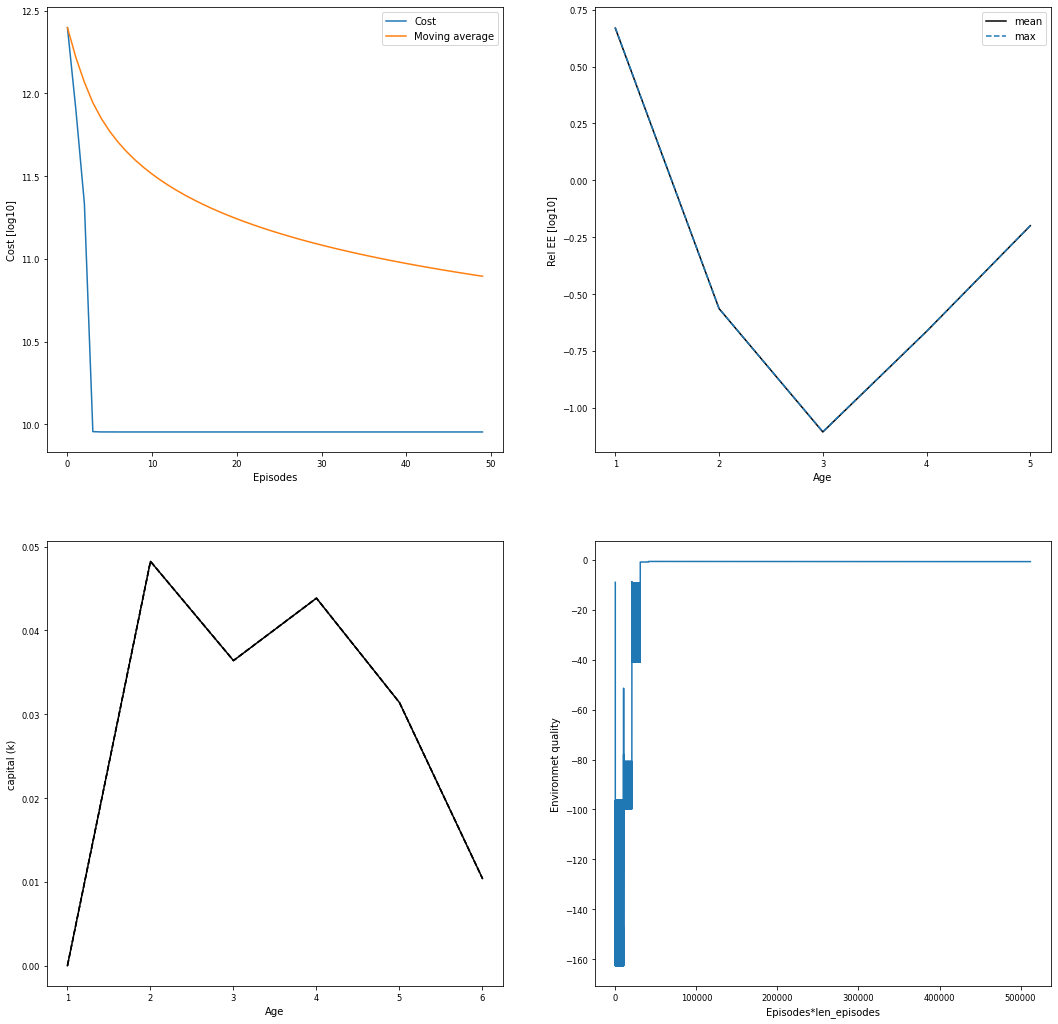

In [13]:
%matplotlib inline
# Helper variables for plotting
all_ages = np.arange(1, A+1)
ages = np.arange(1, A)

# Initialize tensorflow session
sess = tf.Session()

# Initialize interactive plotting
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 18))
plt.ion()
fig.show()
fig.canvas.draw()

# Generate a random starting point
#if data_path:
#    X_data_train = np.load(data_path)
#    print('Loaded initial data from ' + data_path)
#   start_episode = int(re.search('_(.*).npy', data_path).group(1))
#else:
X_data_train = np.random.rand(1, num_input_nodes)
X_data_train[:, 0] = (X_data_train[:, 0] > 0.5)
X_data_train[:, 1:] = X_data_train[:, 1:] + 0.1
X_data_train[:, 9] = -9.0 #Environment starting quality 
assert np.min(np.sum(X_data_train[:, 1:], axis=1, keepdims=True) > 0) == True, 'Starting point has negative aggregate capital (K)!'
print('Calculated a valid starting point')
start_episode = 0

train_seed = 1982

cost_store, mov_ave_cost_store = [], []
quali_env=[]

time_start = datetime.now()
print('start time: {}'.format(time_start))

# Initialize the random variables (neural network weights)
init = tf.global_variables_initializer()

# Initialize saver to save and load previous sessions
saver = tf.train.Saver()

# Run the initializer
sess.run(init)

if sess_path is not None:
    saver.restore(sess, sess_path)
            
for episode in range(start_episode, num_episodes):
    # Simulate data: every episode uses a new training dataset generated on the current
    # iteration's neural network parameters.
    X_episodes = simulate_episodes(sess, X_data_train, len_episodes, print_flag=(episode==0))
    X_data_train = X_episodes[-1, :].reshape([1, -1])
    k_dist_mean = np.mean(X_episodes[:, 10 : 10 + A], axis=0)
    k_dist_min = np.min(X_episodes[:, 10 : 10 + A], axis=0)
    k_dist_max = np.max(X_episodes[:, 10 : 10 + A], axis=0)
    quali_env = np.concatenate((quali_env, X_episodes[:,9]), axis=None)
    ee_error = np.zeros((1, num_agents-1))
    max_ee = np.zeros((1, num_agents-1))

    for epoch in range(epochs_per_episode):
        # Every epoch is one full pass through the dataset. We train multiple passes on 
        # one training set before we resimulate a new dataset.
        train_seed += 1
        minibatch_cost = 0

        # Mini-batch the simulated data
        minibatches = random_mini_batches(X_episodes, minibatch_size, train_seed)

        for minibatch_X in minibatches:
            # Run optimization; i.e., determine the cost of each mini-batch.
            minibatch_cost += sess.run(cost, feed_dict={X: minibatch_X}) / num_minibatches
            if epoch == 0:
                # For the first epoch, save the mean and max euler errors for plotting
                # This way, the errors are calculated out-of-sample.
                opt_euler_ = np.abs(sess.run(opt_euler, feed_dict={X: minibatch_X}))
                ee_error += np.mean(opt_euler_, axis=0) / num_minibatches
                mb_max_ee = np.max(opt_euler_, axis=0, keepdims=True)
                max_ee = np.maximum(max_ee, mb_max_ee)
                

        if epoch == 0:
            # Record the cost and moving average of the cost at the beginning of each
            # episode to track learning progress.
            cost_store.append(minibatch_cost)
            mov_ave_cost_store.append(np.mean(cost_store[-100:]))

        for minibatch_X in minibatches:
            # Take a mini-batch gradient descent training step. That is, update the
            # weights for one mini-batch.
            sess.run(train_step, feed_dict={X: minibatch_X})
            
    #if episode % 20 == 0:
    if episode % 1 == 0:
        # Plot
        # Plot the loss function
        ax1.clear()
        line_cost = ax1.plot(np.log10(cost_store), label='Cost')
        line_mov_ave = ax1.plot(np.log10(mov_ave_cost_store), label='Moving average')
        ax1.set_xlabel('Episodes')
        ax1.set_ylabel('Cost [log10]')
        ax1.legend(loc='upper right')

        # Plot the relative errors in the Euler equation
        ax2.clear()
        ee_mean_cost = ax2.plot(ages, np.log10(ee_error).ravel(), 'k-', label='mean')
        ee_max_cost = ax2.plot(ages, np.log10(max_ee).ravel(), '--', label='max')
        ax2.set_xlabel('Age')
        ax2.set_ylabel('Rel EE [log10]')
        ax2.set_xticks(ages)
        ax2.legend()

        # Plot the capital distribution
        ax3.clear()
        k_mean_cost = ax3.plot(all_ages, k_dist_mean, 'k-')
        k_min_cost = ax3.plot(all_ages, k_dist_min, 'k--')
        k_max_cost = ax3.plot(all_ages, k_dist_max, 'k--')
        ax3.set_xlabel('Age')
        ax3.set_ylabel('capital (k)')
        ax3.set_xticks(all_ages)
        
        # Plot the Env quality
        ax4.clear()
        env_mean_cost = ax4.plot(quali_env, label='Env')
        ax4.set_xlabel('Episodes*len_episodes')
        ax4.set_ylabel('Environmet quality')

    # Print cost and time log
    print('Episode {}: log10(Cost): {:.4f}; time: {}; time since start: {}'.format(episode, 
                                                                                   np.log10(cost_store[-1]), 
                                                                                   datetime.now().time(), 
                                                                                   datetime.now() - time_start))

    if episode % 100 == 0:
        # Save the tensorflow session
        saver.save(sess, './output/sess_{}.ckpt'.format(episode))
        # Save the starting point
        np.save('./output/data_{}.npy'.format(episode), X_data_train)
